![car](car.jpg)

Les compagnies d’assurance investissent beaucoup de temps et d’argent pour optimiser leurs tarifs et estimer avec précision la probabilité que les clients fassent une réclamation. Dans de nombreux pays, il est obligatoire d’avoir une assurance automobile pour conduire un véhicule sur les routes publiques, ce qui rend le marché très vaste !

Sachant cela, On the Road car insurance a demandé vos services pour construire un modèle permettant de prédire si un client fera une réclamation sur son assurance pendant la période de la police. Comme ils ont très peu d’expertise et d’infrastructure pour déployer et surveiller des modèles de machine learning, ils vous ont demandé d’identifier la caractéristique unique qui donne le meilleur modèle en termes de précision, afin qu’ils puissent commencer avec un modèle simple en production.

Ils vous ont fourni leurs données clients sous forme de fichier CSV appelé car_insurance.csv, ainsi qu’un tableau détaillant les noms et descriptions des colonnes ci-dessous.

## Le jeu de données

| Colonne | Description |
|---------|-------------|
| `id` | Identifiant unique du client |
| `age` | Âge du client : <br> <ul><li>`0`: 16-25 ans</li><li>`1`: 26-39 ans</li><li>`2`: 40-64 ans</li><li>`3`: 65 ans et plus</li></ul> |
| `gender` | Sexe du client : <br> <ul><li>`0`: Femme</li><li>`1`: Homme</li></ul> |
| `driving_experience` | Années de conduite du client : <br> <ul><li>`0`: 0-9 ans</li><li>`1`: 10-19 ans</li><li>`2`: 20-29 ans</li><li>`3`: 30 ans et plus</li></ul> |
| `education` | Niveau d'éducation du client : <br> <ul><li>`0`: Pas d'éducation</li><li>`1`: Lycée</li><li>`2`: Université</li></ul> |
| `income` | Niveau de revenu du client : <br> <ul><li>`0`: Pauvreté</li><li>`1`: Classe ouvrière</li><li>`2`: Classe moyenne</li><li>`3`: Classe supérieure</li></ul> |
| `credit_score` | Score de crédit du client (entre zéro et un) |
| `vehicle_ownership` | Statut de propriété du véhicule du client : <br><ul><li>`0`: Ne possède pas son véhicule (en cours de financement)</li><li>`1`: Possède son véhicule</li></ul> |
| `vehicle_year` | Année d'immatriculation du véhicule : <br><ul><li>`0`: Avant 2015</li><li>`1`: 2015 ou après</li></ul> |
| `married` | Statut marital du client : <br><ul><li>`0`: Non marié</li><li>`1`: Marié</li></ul> |
| `children` | Nombre d'enfants du client |
| `postal_code` | Code postal du client | 
| `annual_mileage` | Nombre de kilomètres parcourus par le client chaque année |
| `vehicle_type` | Type de voiture : <br> <ul><li>`0`: Berline</li><li>`1`: Voiture de sport</li></ul> |
| `speeding_violations` | Nombre total d'infractions pour excès de vitesse reçues par le client | 
| `duis` | Nombre de fois que le client a été pris en état d'ivresse au volant |
| `past_accidents` | Nombre total d'accidents antérieurs impliquant le client |
| `outcome` | Si le client a fait une réclamation sur son assurance automobile (variable de réponse) : <br><ul><li>`0`: Pas de réclamation</li><li>`1`: Réclamation faite</li></ul> |

In [5]:
# Importer les bibliothèques requises  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from statsmodels.formula.api import logit

# Chargement des données  
car_insurance = pd.read_csv("car_insurance.csv")

# Afficher les informations du DataFrame  
print(f'{car_insurance.info()}\n')
print(f'{car_insurance.isna().sum()}\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

In [8]:
# ---- Prétraitement des Données ----

# Conversion des colonnes de type objet en int64  
drive_map = {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3}
car_insurance['driving_experience'] = car_insurance['driving_experience'].replace(drive_map)

educ_map = {'none': 0, 'high school': 1, 'university': 2}
car_insurance['education'] = car_insurance['education'].replace(educ_map)

income_map = {'poverty': 0, 'working class': 1, 'middle class': 2, 'upper class': 3}
car_insurance['income'] = car_insurance['income'].replace(income_map)

vehyear_map = {'before 2015': 0, 'after 2015': 1}
car_insurance['vehicle_year'] = car_insurance['vehicle_year'].replace(vehyear_map)

vehtype_map = {'sedan': 0, 'sports car': 1}
car_insurance['vehicle_type'] = car_insurance['vehicle_type'].replace(vehtype_map)

# Vérification des valeurs manquantes  
print(car_insurance['annual_mileage'].describe())

count     9043.000000
mean     11697.003207
std       2818.434528
min       2000.000000
25%      10000.000000
50%      12000.000000
75%      14000.000000
max      22000.000000
Name: annual_mileage, dtype: float64


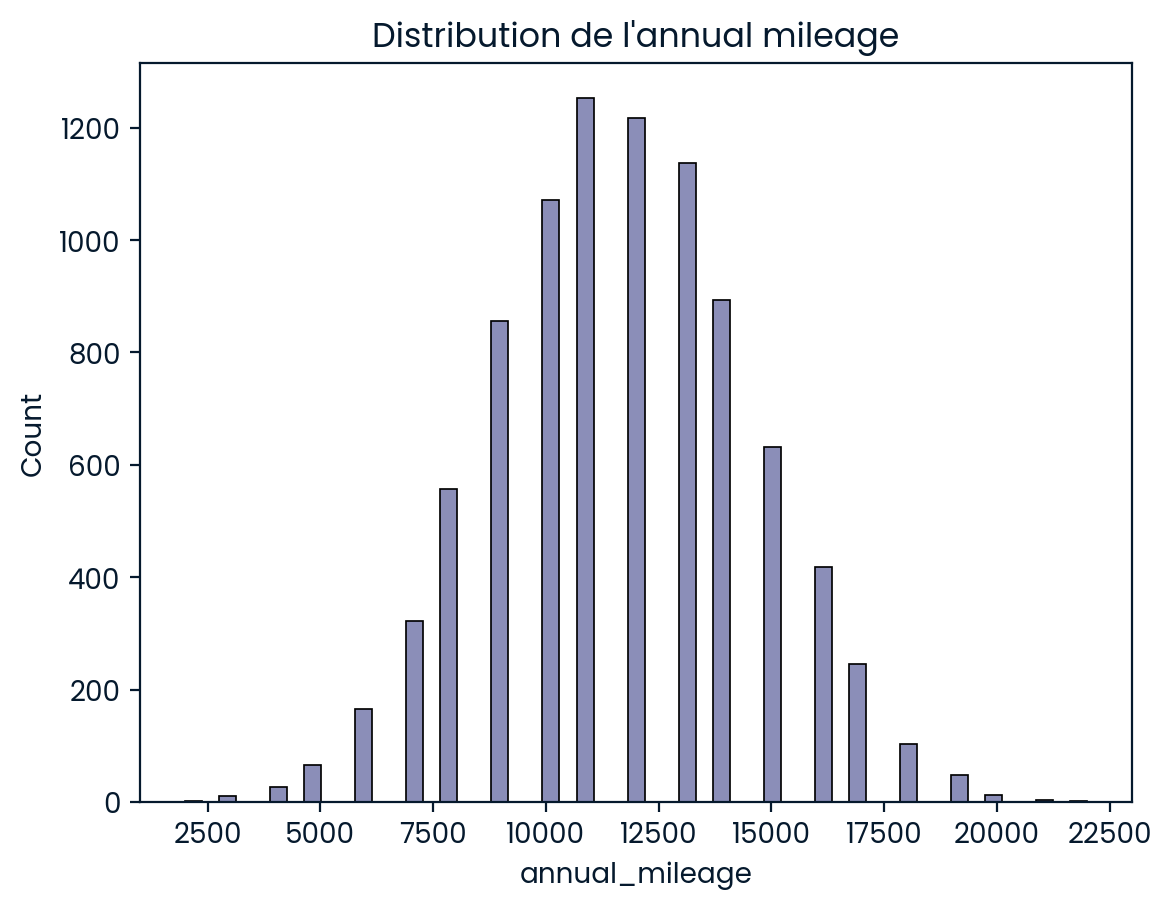

In [9]:
sns.histplot(x='annual_mileage', data=car_insurance)
plt.title("Distribution de l'annual mileage")
plt.show()

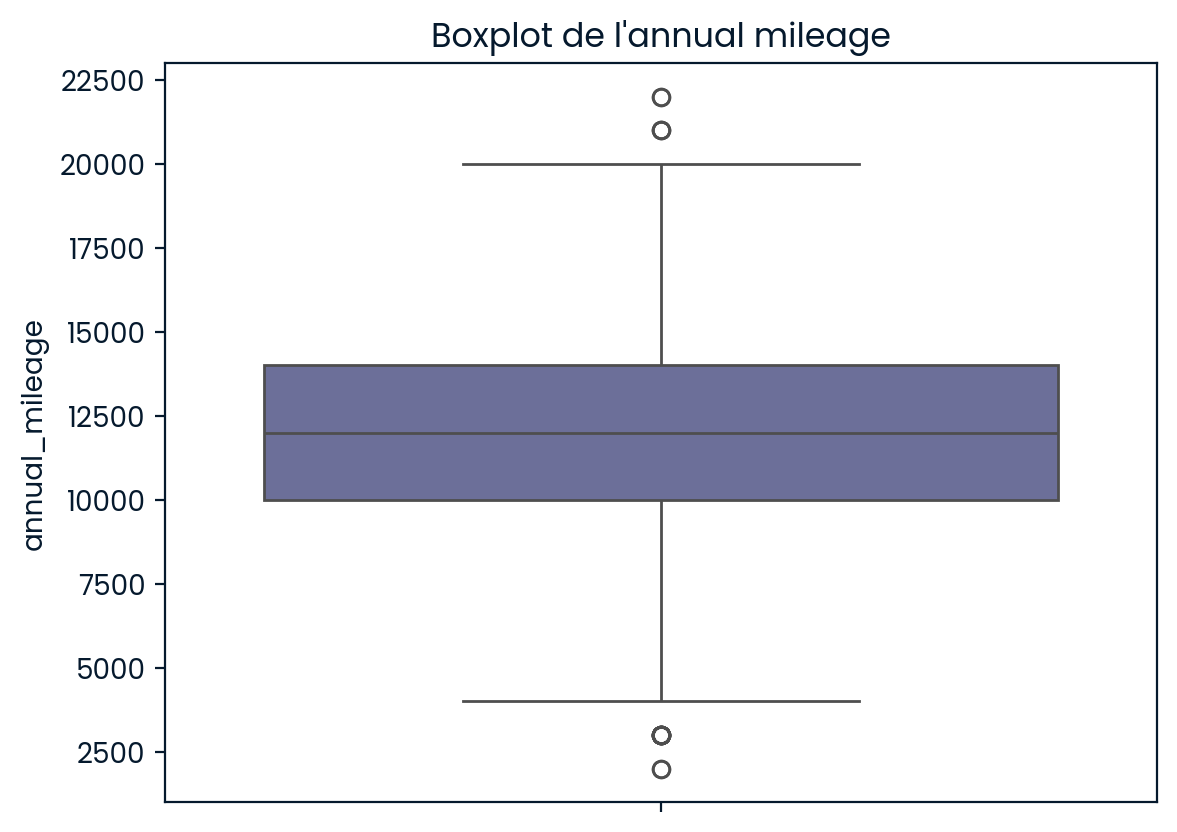

In [10]:
sns.boxplot(y='annual_mileage', data=car_insurance)
plt.title("Boxplot de l'annual mileage")
plt.show()

In [13]:
# Traitement des valeurs manquantes  
median_credit = car_insurance['credit_score'].median()
median_mile = car_insurance['annual_mileage'].median()

car_insurance = car_insurance.fillna({'credit_score': median_credit})
car_insurance = car_insurance.fillna({'annual_mileage': median_mile})

# ---- Modélisation ----

# Liste pour stocker les modèles  
models = []

# Récupération des caractéristiques à utiliser pour la modélisation  
features = car_insurance.drop(columns=['outcome', 'id']).columns

# Construction des modèles pour chaque caractéristique  
for col in features:
    model = logit(f"outcome ~ {col}", data=car_insurance).fit()
    models.append(model)

# ---- Évaluation de la Performance ----

# Liste pour stocker les précisions  
acc = []

for model in models:
    confusion_matrix = model.pred_table()
    
    true_negative = confusion_matrix[0, 0]
    true_positive = confusion_matrix[1, 1]
    false_negative = confusion_matrix[0, 1]
    false_positive = confusion_matrix[1, 0]
    
    accuracy = (true_negative + true_positive) / (true_negative + true_positive + false_negative + false_positive)
    acc.append(accuracy)

# Identification de la meilleure caractéristique  
best_feature_index = acc.index(max(acc))
best_feature = features[best_feature_index]

# Création du DataFrame pour le meilleur prédicteur  
best_feature_df = pd.DataFrame({
    'best_feature': best_feature,
    'best_accuracy': max(acc)
}, index=[0])

Optimization terminated successfully.
         Current function value: 0.511794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595431
  

In [12]:
# Afficher le meilleur prédicteur  
print(best_feature_df)

         best_feature  best_accuracy
0  driving_experience         0.7771
